In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

def residual_block(x, filters, kernel_size=2, stride=1):
    # Atajo o Shortcut: es la entrada al bloque, se usa para sumarlo al final con
    #el resultado de pasar esta misma entrada por las capas convolucionales
    shortcut = x
    
    # Primer capa convolucional
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Segunda capa convolucional
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Sumar el atajo con la salida de las capas convolucionales , generar la salida del bloque
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    
    return x

# Definir el modelo ResNet
def build_resnet():
    input_layer = layers.Input(shape=(28, 28, 3))
    
    # Capa convolucional inicial
    x = layers.Conv2D(32, 3, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Agregar los bloques residuales, en este caso se itera por 3 ciclos, para pasar x 
    # por 3 bloques identicos
    for _ in range(3):  # Three residual blocks
        x = residual_block(x, 32)
    
    # Pooling promedi
    x = layers.GlobalAveragePooling2D()(x)
    
    # Fully Connected 
    x = layers.Dense(128, activation='relu')(x)
    
    # Output Layer - capa de salida
    output_layer = layers.Dense(1, activation='softmax')(x)  
    
    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

# Instantiate the model
model = build_resnet()

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# imprimir resumen
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 28, 28, 32)   0           ['batch_normalization[0][0]']

In [2]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definir los parametros
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Cargar y procesar sus datos (Asumiendo que los tiene en un directorio)
train_generator = datagen.flow_from_directory(
      'C:/Users/paola/OneDrive/Escritorio/histopatologia/train',
    target_size=(28, 28),  # Ajustar
    batch_size=2048,           # Ajustar
    class_mode='binary' # Depende de la tarea (binary , categorical classification)
)


datagen_test = ImageDataGenerator()
test_generator = datagen_test.flow_from_directory(
     'C:/Users/paola/OneDrive/Escritorio/histopatologia/test',
    target_size=(28,28),  # Ajustar
    batch_size=2048,           # Ajustar
    class_mode='binary' # Depende de la tarea (binary , categorical classification)
)


Found 194001 images belonging to 2 classes.
Found 83523 images belonging to 2 classes.


In [3]:
# entrenar su modelo
model.fit(train_generator, epochs=5)

Epoch 1/5
95/95 [==============================] - 1012s 11s/step - loss: 0.3752 - accuracy: 0.7164
Epoch 2/5
95/95 [==============================] - 1032s 11s/step - loss: 0.3301 - accuracy: 0.7164
Epoch 3/5
95/95 [==============================] - 997s 10s/step - loss: 0.3207 - accuracy: 0.7164
Epoch 4/5
95/95 [==============================] - 992s 10s/step - loss: 0.3124 - accuracy: 0.7164
Epoch 5/5
95/95 [==============================] - 1105s 12s/step - loss: 0.3046 - accuracy: 0.7164


In [5]:
_, accuracy = model.evaluate(x=test_generator)
print('Accuracy: %.2f' % (accuracy*100))

41/41 [==============================] - 289s 7s/step - loss: 1.0475 - accuracy: 0.7154
Accuracy: 71.54


41/41 [==============================] - 799s 20s/step
Matriz de Confusión:
[[    0 23770]
 [    0 59753]]
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     23770
           1       0.72      1.00      0.83     59753

    accuracy                           0.72     83523
   macro avg       0.36      0.50      0.42     83523
weighted avg       0.51      0.72      0.60     83523

AUC (Área bajo la curva ROC): 0.5


C:\Users\paola\anaconda3\envs\deeplearning\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\paola\anaconda3\envs\deeplearning\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\paola\anaconda3\envs\deeplearning\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


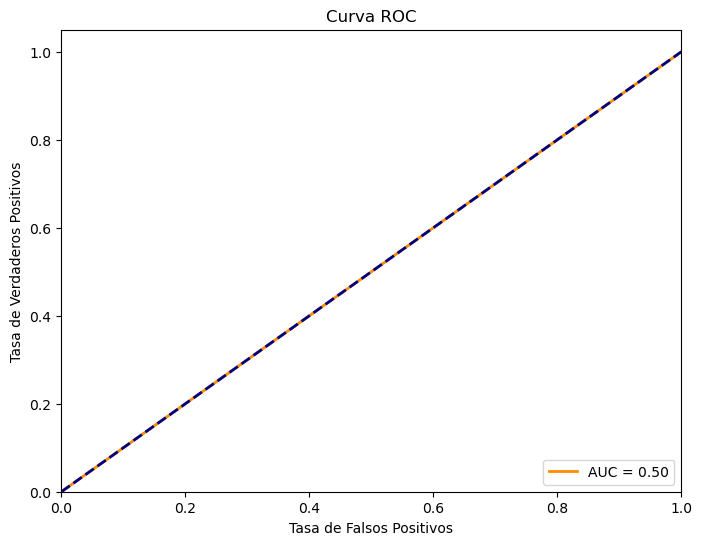

In [6]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predice las clases en el conjunto de prueba
y_pred = model.predict(test_generator)
y_pred_binary = (y_pred > 0.5)  # Convertir las probabilidades en etiquetas binarias

# Obtén las etiquetas reales del conjunto de prueba
y_true = test_generator.classes

# Calcula la matriz de confusión
confusion = confusion_matrix(y_true, y_pred_binary)
print("Matriz de Confusión:")
print(confusion)

# Genera un informe de clasificación
classification_rep = classification_report(y_true, y_pred_binary)
print("Informe de Clasificación:")
print(classification_rep)

# Calcula la curva ROC y el área bajo la curva (AUC)
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)
print("AUC (Área bajo la curva ROC):", roc_auc)

# Trama la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


41/41 [==============================] - 194s 5s/step


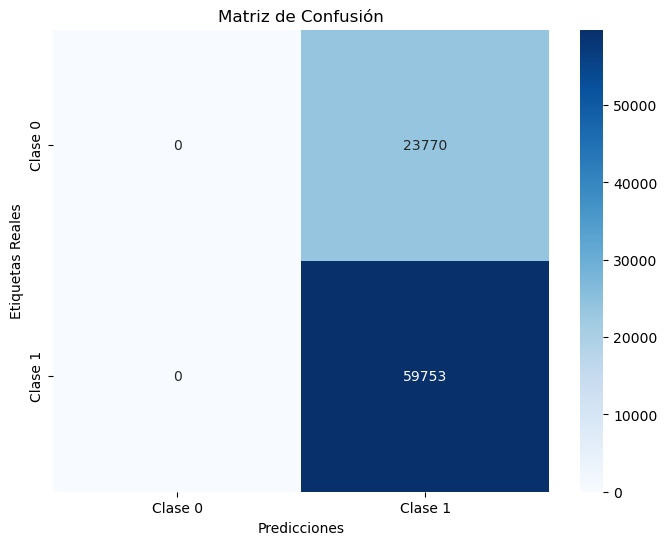

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predice las clases en el conjunto de prueba
y_pred = model.predict(test_generator)
y_pred_binary = (y_pred > 0.5)  # Convertir las probabilidades en etiquetas binarias

# Obtén las etiquetas reales del conjunto de prueba
y_true = test_generator.classes

# Calcula la matriz de confusión
confusion = confusion_matrix(y_true, y_pred_binary)

# Define las etiquetas de las clases
class_labels = ['Clase 0', 'Clase 1']  # Ajusta las etiquetas según tu problema

# Crea una visualización de la matriz de confusión estilizada
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.title('Matriz de Confusión')
plt.show()
